# **Import các thư viện cần thiết và đọc file**



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read *.csv files
%cd /content/drive/MyDrive
score = pd.read_csv("score_training.csv")
wecode = pd.read_csv("wecode.csv")

/content/drive/MyDrive


In [ ]:
wecode.head()

,id,assignment_id,problem_id,user_id,is_final,status,pre_score,coefficient,file_name,language_id,created_at,updated_at
0,4,0,3,4,1,SCORE,10000,100,solution-0,2,2020-10-30 10:58:11,2020-10-30 10:58:19
1,5,0,4,4,1,SCORE,10000,100,solution-1,2,2020-10-30 11:07:09,2020-10-30 11:07:17
2,6,0,5,4,0,Compilation Error,0,100,solution-2,2,2020-10-30 11:08:01,2020-10-30 11:23:36
3,7,0,5,4,0,Compilation Error,0,100,solution-3,2,2020-10-30 11:11:41,2020-10-30 11:11:42
4,8,0,5,4,0,Compilation Error,0,100,solution-4,2,2020-10-30 11:15:06,2020-10-30 11:15:07


In [ ]:
score

,id,QT,GK,TH,CK,TBM,TBTL
0,22,10,9,8.5,8.5,8.8,8.52
1,24,10,8,10,9.5,9.4,8.41
2,27,10,10,10,10,10,8.67
3,28,10,9.5,7.5,9.5,9.2,7.39
4,29,10,9.5,5,8.5,8.2,8.05
...,...,...,...,...,...,...,...
970,1857,5,4.5,10,4,6,6.03
971,1859,8,5,10,1.5,5.4,5.06
972,1862,5,6.5,1,7.5,5.1,4.71
973,1865,6.5,,3,7.5,,6.89


# **Xử lý dữ liệu**
Để có một cái nhìn tổng quát, từ file wecode.csv ta tổng hợp lại thành một bảng mới chứa một vài đặc điểm (gộp theo id sinh viên) mà được dự đoán sẽ có ảnh hưởng đến điểm cuối kỳ của sinh viên như sau:

- Tổng số problems đã submit của từng SV
- Tổng số lần submits của từng SV
- Tổng số submits đúng của từng SV
- Tổng số problems được submit đúng của từng SV
- Tổng điểm Pre_score của từng SV

In [ ]:
new_wecode = pd.DataFrame(wecode['user_id'])
new_wecode['Sum_Problems'] = pd.DataFrame(wecode['is_final'])
new_wecode.insert(2,'Sum_Submits', 1)
new_wecode['Sum_Correct_Submits'] = pd.DataFrame(map(int, (wecode['pre_score'] == 10000)))
new_wecode['Sum_Correct_Problems'] = pd.DataFrame(map(int, (wecode['pre_score'] == 10000) & (wecode['is_final'] == 1)))
new_wecode['Sum_Pre_Scores'] = wecode.loc[wecode['is_final'] == 1, ['pre_score']]
new_wecode.columns = ['id', 'Sum_Problems', 'Sum_Submits','Sum_Correct_Submits', 'Sum_Correct_Problems', 'Sum_Pre_Scores']
new_wecode = new_wecode.groupby(['id']).sum()
new_wecode

,Sum_Problems,Sum_Submits,Sum_Correct_Submits,Sum_Correct_Problems,Sum_Pre_Scores
id,,,,,
1,2,2,1,1,10000.0
4,38,54,44,37,370000.0
5,5,6,3,3,30000.0
6,88,130,89,85,850000.0
7,2,5,0,0,9209.0
...,...,...,...,...,...
1860,48,76,29,28,329665.0
1862,6,12,4,4,40000.0
1864,63,187,30,28,439741.0


Chỉ quan tâm đến điểm cuối kỳ của SV nên ta chỉ cần 2 thông tin trong score_training:
- id
- CK

In [ ]:
new_score = score[['id', 'CK']]
# Thay header cho trùng với dữ liệu wecode
new_score.columns = ['id', 'CK']
# Thay đổi từ Object sang Numberic
new_score['CK'] = new_score['CK'].apply(pd.to_numeric, errors='coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
new_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      975 non-null    int64  
 1   CK      920 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 15.4 KB


Nhận thấy bảng new_score có nhiều ô 'CK' là null nên ta loại bỏ trong tập train và lấy thành tập score_predict để sau này dự đoán.

In [ ]:
# Create new dataframes from original
score_train = new_score.dropna(how='any')
score_predict = new_score[new_score.isna().any(axis=1)]

# Index starts from 0
score_train = score_train.reset_index()
score_train = score_train.drop(columns=['index'])
score_predict = score_predict.reset_index()
score_predict = score_predict.drop(columns=['index'])

Kết 2 bảng new_wecode và score_train theo id sinh viên.

In [ ]:
data_train = pd.merge(new_wecode,score_train, on = 'id', how = 'inner')
data_predict = pd.merge(new_wecode,score_predict, on = 'id', how = 'inner')

In [ ]:
data_train

,id,Sum_Problems,Sum_Submits,Sum_Correct_Submits,Sum_Correct_Problems,Sum_Pre_Scores,CK
0,24,77,164,80,72,750299.0,9.5
1,27,5,13,4,3,39000.0,10.0
2,29,80,199,75,72,762760.0,8.5
3,34,84,218,81,81,822888.0,6.5
4,35,151,297,152,145,1477000.0,4.5
...,...,...,...,...,...,...,...
801,1856,31,64,23,23,270790.0,7.5
802,1857,40,55,37,37,386000.0,4.0
803,1859,30,31,3,3,39000.0,1.5
804,1862,6,12,4,4,40000.0,7.5


In [ ]:
data_predict

,id,Sum_Problems,Sum_Submits,Sum_Correct_Submits,Sum_Correct_Problems,Sum_Pre_Scores,CK
0,51,39,86,40,38,380000.0,NaN
1,240,138,623,133,126,1309761.0,NaN
2,391,113,379,104,102,1059240.0,NaN
3,513,140,672,135,130,1319307.0,NaN
4,586,127,296,127,123,1238947.0,NaN
5,705,118,328,122,118,1180000.0,NaN
6,772,124,292,115,112,1200552.0,NaN
7,774,99,197,101,98,988888.0,NaN
8,776,100,264,99,99,998888.0,NaN
9,792,161,422,180,158,1602776.0,NaN


Loại bỏ các ô NaN trong tập train

In [ ]:
# Drop NaN value
data_train.dropna(axis=0, inplace=True)
data_train

,id,Sum_Problems,Sum_Submits,Sum_Correct_Submits,Sum_Correct_Problems,Sum_Pre_Scores,CK
0,24,77,164,80,72,750299.0,9.5
1,27,5,13,4,3,39000.0,10.0
2,29,80,199,75,72,762760.0,8.5
3,34,84,218,81,81,822888.0,6.5
4,35,151,297,152,145,1477000.0,4.5
...,...,...,...,...,...,...,...
801,1856,31,64,23,23,270790.0,7.5
802,1857,40,55,37,37,386000.0,4.0
803,1859,30,31,3,3,39000.0,1.5
804,1862,6,12,4,4,40000.0,7.5


# **Vẽ Scatter plot**
Vẽ scatter plot để phân tích nhận biết các thông tin sẽ ảnh hưởng đến điểm CK của sinh viên.

In [ ]:
def Scatter_Plot(x_label,y_label,x,y):
  fig = plt.figure()
  plt.scatter(x,y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  fig.set_figheight(9)
  fig.set_figwidth(11)
  plt.show()

**1. Tỉ lệ giữa Tổng số problem đã giải đúng và tổng số problems đã submit với điểm cuối kỳ của từng sinh viên.**

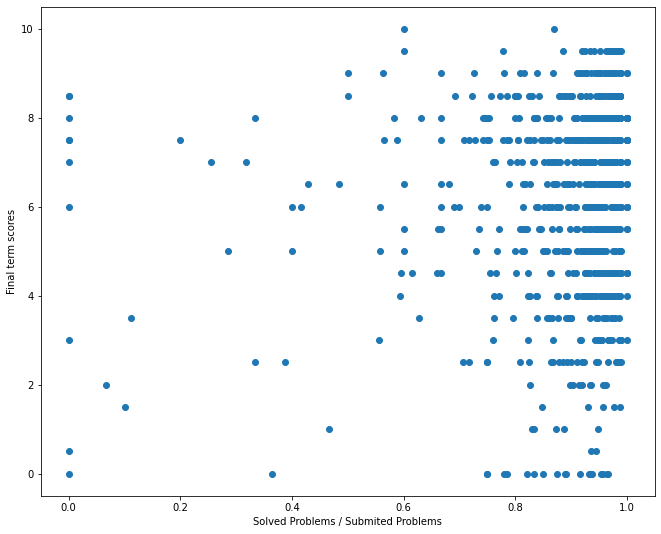

In [ ]:
plot_1 = data_train["Sum_Correct_Problems"]/ data_train["Sum_Problems"]
Scatter_Plot("Solved Problems / Submited Problems","Final term scores",plot_1,data_train["CK"])

**2. Tỉ lệ giữa tổng số problems đã submit trên tổng số lần submit với điểm CK của từng sinh viên**





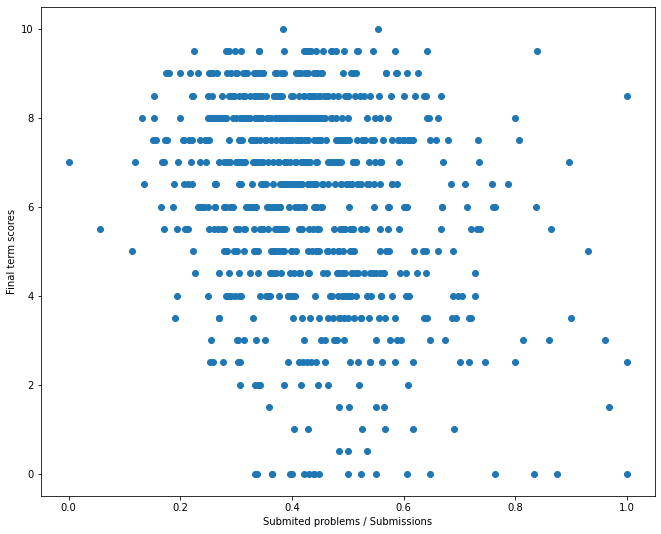

In [ ]:
plot_2 = data_train["Sum_Problems"] / data_train["Sum_Submits"]
Scatter_Plot("Submited problems / Submissions", "Final term scores", plot_2,data_train["CK"])

**3. Tỉ lệ giữa tổng số submit đúng trên tổng số lần submit với điểm CK của từng sinh viên**


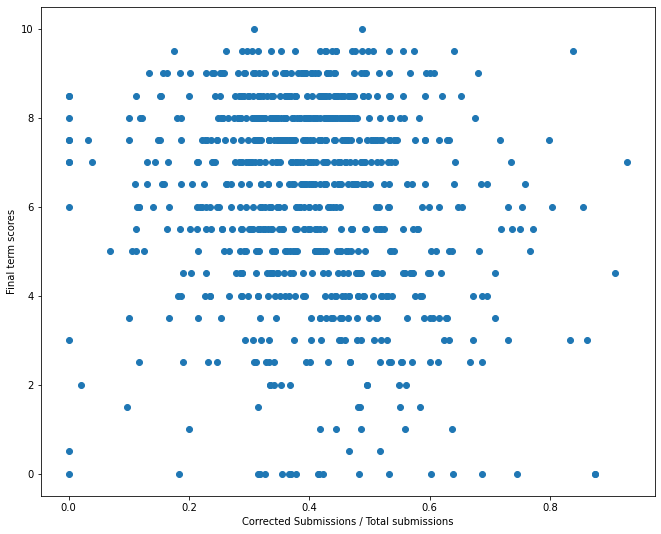

In [ ]:
plot_3 = data_train["Sum_Correct_Submits"] / data_train["Sum_Submits"]
Scatter_Plot("Corrected Submissions / Total submissions", "Final term scores",plot_3, data_train["CK"])

**4. Tỉ lệ giữa tổng điểm pre_score (điểm này tính ở lần nộp is_final) với điểm CK của từng sinh viên**

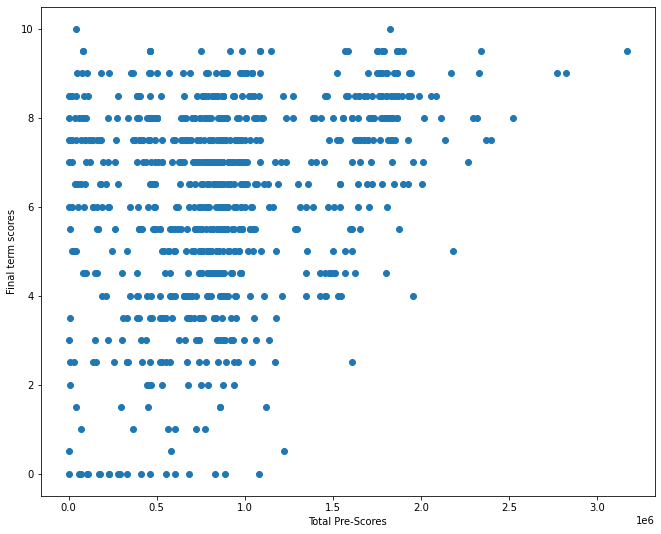

In [ ]:
Scatter_Plot("Total Pre-Scores", "Final term scores",data_train["Sum_Pre_Scores"], data_train["CK"])

**5. Tổng số lần submit của từng SV với điểm cuối kỳ**



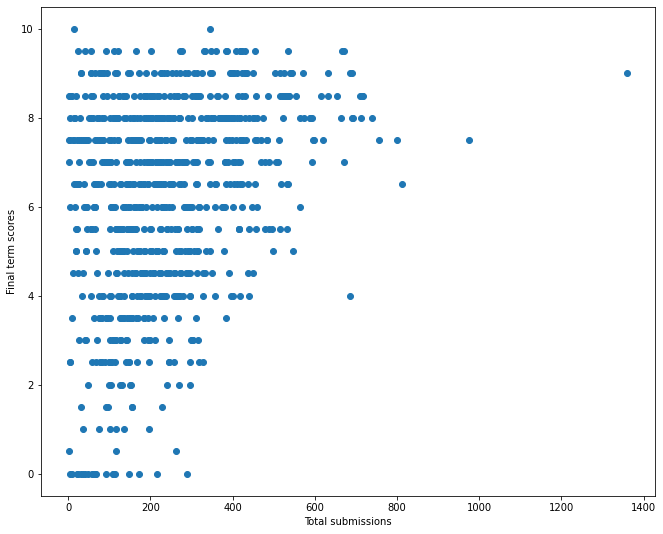

In [ ]:
Scatter_Plot("Total submissions", "Final term scores",data_train["Sum_Submits"], data_train["CK"])

**6.Tổng số problem đã submit của từng SV với điểm CK**




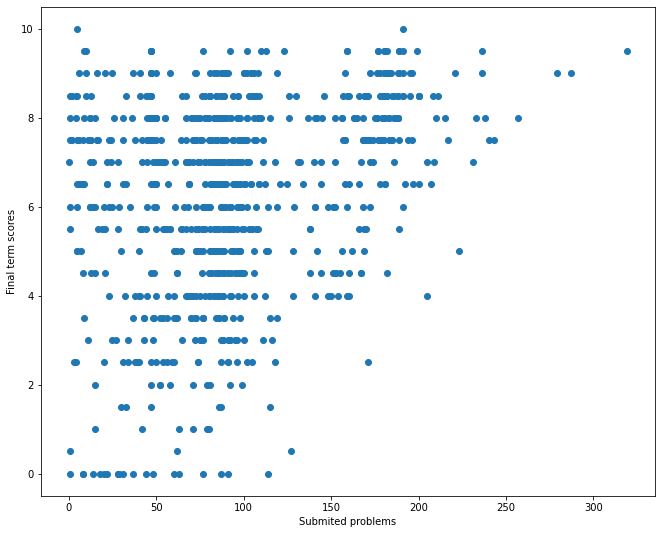

In [ ]:
Scatter_Plot("Submited problems", "Final term scores", data_train["Sum_Problems"], data_train["CK"])

# **Build Model**

In [ ]:
data_train

,id,Sum_Problems,Sum_Submits,Sum_Correct_Submits,Sum_Correct_Problems,Sum_Pre_Scores,CK
0,24,77,164,80,72,750299.0,9.5
1,27,5,13,4,3,39000.0,10.0
2,29,80,199,75,72,762760.0,8.5
3,34,84,218,81,81,822888.0,6.5
4,35,151,297,152,145,1477000.0,4.5
...,...,...,...,...,...,...,...
801,1856,31,64,23,23,270790.0,7.5
802,1857,40,55,37,37,386000.0,4.0
803,1859,30,31,3,3,39000.0,1.5
804,1862,6,12,4,4,40000.0,7.5


Chia tập train ra thành 2 phần, 80% để train và 20% để test

In [ ]:
y = data_train['CK']
X = data_train.drop('CK', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) # Random_state = 42: Doesnt change each time we run the code
X_train

,id,Sum_Problems,Sum_Submits,Sum_Correct_Submits,Sum_Correct_Problems,Sum_Pre_Scores
787,1710,49,135,46,46,474250.0
637,1421,183,596,184,179,1813888.0
444,950,89,416,77,72,803433.0
332,714,14,35,11,11,110000.0
291,611,200,654,208,190,1940888.0
...,...,...,...,...,...,...
71,185,21,55,14,14,163602.0
106,263,4,16,3,3,37000.0
270,578,38,84,30,30,362422.0
435,932,86,185,84,77,825221.0


**Train Model and Predict**

In [ ]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pre = list(map(lambda x: np.round(x*2)/2 ,LR_model.predict(X_test)))
MSE = mean_squared_error(y_pre, y_test)
print(f'MSE: {MSE}')

MSE: 3.9660493827160495


Điểm CK của các sinh viên ở tập predict ở phần trên

In [ ]:
col_train = ['id',	'Sum_Problems',	'Sum_Submits',	'Sum_Correct_Submits',	'Sum_Correct_Problems',	'Sum_Pre_Scores']
data_predict['CK'] = list(map(lambda x: np.round(x*2)/2, LR_model.predict(np.array(data_predict[col_train]))))
data_predict

,id,Sum_Problems,Sum_Submits,Sum_Correct_Submits,Sum_Correct_Problems,Sum_Pre_Scores,CK
0,51,39,86,40,38,380000.0,5.5
1,240,138,623,133,126,1309761.0,7.5
2,391,113,379,104,102,1059240.0,6.0
3,513,140,672,135,130,1319307.0,6.5
4,586,127,296,127,123,1238947.0,6.0
5,705,118,328,122,118,1180000.0,6.5
6,772,124,292,115,112,1200552.0,7.5
7,774,99,197,101,98,988888.0,6.5
8,776,100,264,99,99,998888.0,6.5
9,792,161,422,180,158,1602776.0,7.0


# **Nhận xét:**

Kết quả MSE khá cao (MSE: 3.9660493827160495) có thể nguyên nhân là do:

- Các thông tin mà nhóm đã dự đoán là ảnh hưởng đến điểm CK có thể còn ít, chưa thật sự tốt, hoặc có trọng số ảnh hưởng khác nhau.

- Việc làm bài wecode của SV trên thực tế có vẻ như chưa thực sự ảnh hưởng lớn đến điểm thi CK của SV. Vì các bài wecode mang tính thực hành cao và có nhiều bài tập khó, còn thi thì có cả phần lý thuyết và thực hành ở mức không khó. SV điểm CK cao có thể là SV không thực sự giỏi thực hành nhưng siêng năng học lý thuyết và hiểu bài, có thể code được các bài dễ và trung bình (mà thi CK cũng ở mức độ này).
